In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import time
from sklearn.manifold import TSNE

In [3]:
import pickle
import json
import string

In [4]:
import urllib.request

In [5]:
url = "https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt"

response = urllib.request.urlopen(url)
text = response.read().decode("utf-8")

In [6]:
%pip install nltk

     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     --------- ------------------------------ 10.2/41.5 kB ? eta -:--:--
     ---------------------------- --------- 30.7/41.5 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 41.5/41.5 kB 496.9 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------- ------------------------------- 0.3/1.5 MB 10.2 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.5 MB 5.7 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.5 MB 4.9 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.5 MB 5.4 MB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 4.7 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.5 MB 4.6 MB/s eta 0:00:01
   --------------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [8]:
# Preprocessing function
def preprocess_text(text):
    # Tokenize the text into words
    tokens = nltk.tokenize.word_tokenize(text.lower())
    # Remove punctuation and non-alphabetic tokens
    words = [word for word in tokens if word.isalpha()]
    return words

words = preprocess_text(text)

In [9]:
print(words[:10])

['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family']


In [10]:
# Create a vocabulary mapping
vocab = sorted(set(words))  # Unique words in the text
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for idx, word in enumerate(vocab)}

In [11]:
# Step 2: Define the MLP Model
class MLPTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(MLPTextGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.activation = nn.ReLU()  # Change this to another activation function if needed

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)  # Average over the sequence length
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

In [12]:
context_length = 5

# Step 3: Prepare training data
def prepare_data(words, context_length):
    X, y = [], []
    for i in range(context_length, len(words)):
        X.append([word_to_idx[word] for word in words[i-context_length:i]])
        y.append(word_to_idx[words[i]])
    return np.array(X), np.array(y)


X, y = prepare_data(words, context_length)
print(X.shape, y.shape)

(560989, 5) (560989,)


In [13]:
# Step 4: Initialize the model, define the loss function and optimizer
embedding_dim = 64
hidden_dim = 128
model = MLPTextGenerator(vocab_size, embedding_dim, hidden_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [16]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [18]:
# Build the MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=context_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


c:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 453s 36ms/step - accuracy: 0.0956 - loss: 6.5208 - val_accuracy: 0.1307 - val_loss: 5.9385
Epoch 2/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 454s 36ms/step - accuracy: 0.1398 - loss: 5.6020 - val_accuracy: 0.1379 - val_loss: 5.9354
Epoch 3/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 443s 35ms/step - accuracy: 0.1541 - loss: 5.2700 - val_accuracy: 0.1399 - val_loss: 6.0886
Epoch 4/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 442s 35ms/step - accuracy: 0.1646 - loss: 5.0559 - val_accuracy: 0.1387 - val_loss: 6.3160
Epoch 5/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 445s 35ms/step - accuracy: 0.1738 - loss: 4.8946 - val_accuracy: 0.1360 - val_loss: 6.5599
Epoch 6/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 501s 35ms/step - accuracy: 0.1820 - loss: 4.7595 - val_accuracy: 0.1347 - val_loss: 6.8344
Epoch 7/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 456s 36ms/step - accuracy: 0.1894 - loss: 4.6521 - val_accuracy: 0.1317 - val_loss: 7.0996
Epoch 8/10
12623/12623 ━━━━━━━━━━━━━━━━━━━━ 498s 36ms/s

In [ ]:
# # Step 5: Train the model
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X)
#     loss = criterion(outputs, y)
#     loss.backward()
#     optimizer.step()
    
#     if (epoch + 1) % 5 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [21]:
# Step 6: Save the model and vocabulary using pickle
with open('mlp_text_generator.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('vocab.json', 'w') as f:
    json.dump(word_to_idx, f)

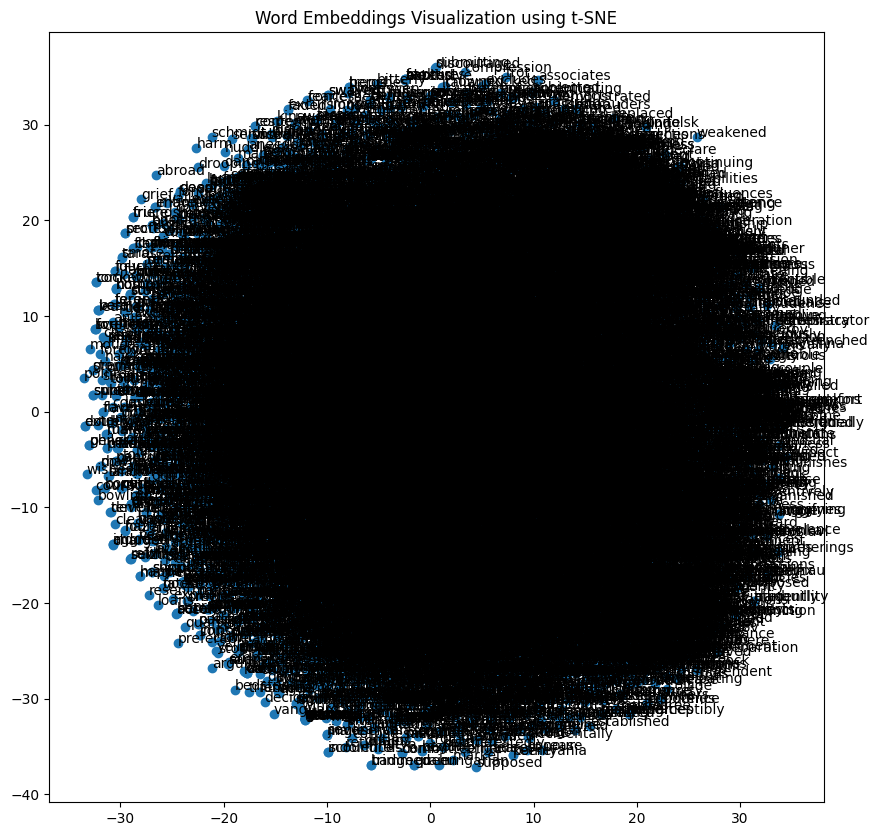

In [20]:
# Extract embeddings
embeddings = model.layers[0].get_weights()[0]

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=seed)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, word in enumerate(vocab):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.title('Word Embeddings Visualization using t-SNE')
plt.show()